### **Read data**

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

data_root = './dataset'
train_path = os.path.join(data_root, 'train.csv')
val_path = os.path.join(data_root, 'val.csv')
test_path = os.path.join(data_root, 'test.csv')

In [2]:
train = pd.read_csv(train_path)
train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,0.069444,1,0,0,0,0,1,0,0,1,0.571998,0.043925,0,0,1,0,1,0,0,0,0,0,1
1,0,0,0,0,0.291667,1,0,1,0,1,1,0,0,1,0.418535,0.143036,0,1,0,0,0,1,0,0,0,1,0
2,0,0,1,1,0.763889,1,1,0,0,0,0,0,0,1,0.073742,0.157997,0,0,0,1,0,0,1,0,1,0,0
3,1,0,0,0,0.277778,1,0,0,0,0,0,1,0,0,0.603388,0.187226,0,0,1,0,1,0,0,0,0,1,0
4,0,0,1,0,0.333333,1,0,0,0,0,0,0,0,0,0.021425,0.053543,0,0,0,1,0,1,0,0,1,0,0


In [3]:
val = pd.read_csv(val_path)
val.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,1,0,0,0,0.819444,0,0,0,0,0,1,1,1,1,0.333333,0.344680,1,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0.819444,1,1,1,1,0,0,1,0,1,0.762332,0.643763,0,1,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0.055556,1,1,0,0,0,1,0,0,0,0.623318,0.036193,0,1,0,1,0,0,0,1,0,0,1
3,0,0,0,0,0.569444,1,1,0,1,1,0,1,1,1,0.877429,0.510576,0,1,0,1,0,0,0,0,1,0,1
4,1,0,0,0,0.638889,0,0,1,0,1,1,1,1,1,0.423518,0.331710,1,0,0,0,0,1,1,0,0,0,0


In [4]:
test = pd.read_csv(test_path)
test.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,1,0,0.013889,0,0,0,0,0,0,0,0,1,0.065272,0.000692,1,0,0,1,0,0,0,0,1,0,1
1,1,0,0,0,0.569444,1,1,0,0,0,0,0,0,1,0.069756,0.112814,0,0,1,1,0,0,1,0,0,0,0
2,0,0,1,1,0.722222,1,0,0,0,0,0,0,0,0,0.010962,0.116882,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0.013889,1,0,0,0,1,0,0,0,0,0.578974,0.006641,0,1,0,1,0,0,0,0,1,0,1
4,1,0,0,0,0.930556,1,0,0,0,0,1,0,0,0,0.321873,0.374025,1,0,0,0,0,1,1,0,0,0,0


In [5]:
print('Training set: ', train.shape)
print('Validation set: ', val.shape)
print('Testing set: ', test.shape)

Training set:  (7246, 27)
Validation set:  (705, 27)
Testing set:  (1409, 27)


### **Split into X,y**

In [6]:
X_train = train.loc[:, train.columns != 'Churn'] # Features
y_train = train.loc[:, train.columns == 'Churn'] # Target

X_val = val.loc[:, val.columns != 'Churn'] # Features
y_val = val.loc[:, val.columns == 'Churn'] # Target

X_test = test.loc[:, test.columns != 'Churn'] # Features
y_test = test.loc[:, test.columns == 'Churn'] # Target

In [7]:
X_train.shape

(7246, 26)

### **Bagging SVM**

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

svm_classifier = SVC(random_state=42)

bagging_svm = BaggingClassifier(estimator=svm_classifier, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm.fit(X_train, y_train.values.ravel())

print(f'Training time: {(time.time()-t0):.2f} s')

Training time: 5.96 s


Accuracy: 0.7730
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       515
           1       0.56      0.69      0.62       190

    accuracy                           0.77       705
   macro avg       0.72      0.75      0.73       705
weighted avg       0.79      0.77      0.78       705



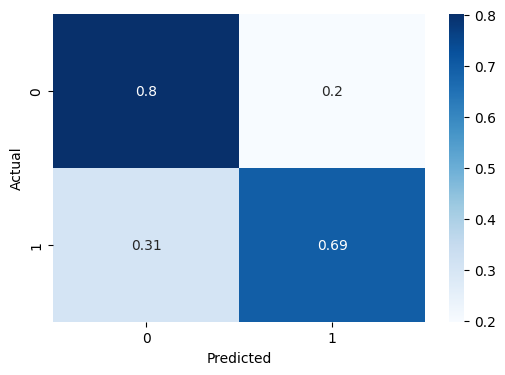

In [9]:
y_val_bagging_pred = bagging_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_val_bagging_pred)

print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_pred))
bagging_confmat = confusion_matrix(y_val, y_val_bagging_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
svm_classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### *Hyper-parameters Tuning for SVM*

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf','sigmoid']}
svm_grid = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy', verbose=3)
svm_grid.fit(X_train,y_train.values.ravel())

# print best parameter after tuning 
print(svm_grid.best_params_) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.743 total time=   2.5s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.4s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.7s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.4s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.4s
[CV 1/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.743 total time=   1.7s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   1.7s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   2.1s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   1.8s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   1.6s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.746 total time=   2.8s
[CV 2/5] END ....C=0.1, gamma=0.001, kerne

In [12]:
svm_grid.best_estimator_

SVC(C=1, gamma=1, random_state=42)

In [13]:
svm_grid.best_score_

0.8287450560434069

#### **Tuned Bagging SVM**

In [14]:
best_c = svm_grid.best_params_.get('C')
best_gamma = svm_grid.best_params_.get('gamma')

# Use Hyper-parameter tuned SVM as base estimator
svm_tune = SVC(gamma=best_gamma, C=best_c)

bagging_svm_tune = BaggingClassifier(estimator=svm_tune, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm_tune.fit(X_train, y_train.values.ravel())

print(f'Training time: {time.time()-t0:.2f} s')

Training time: 9.51 s


Accuracy: 0.7716
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       515
           1       0.58      0.55      0.56       190

    accuracy                           0.77       705
   macro avg       0.71      0.70      0.70       705
weighted avg       0.77      0.77      0.77       705



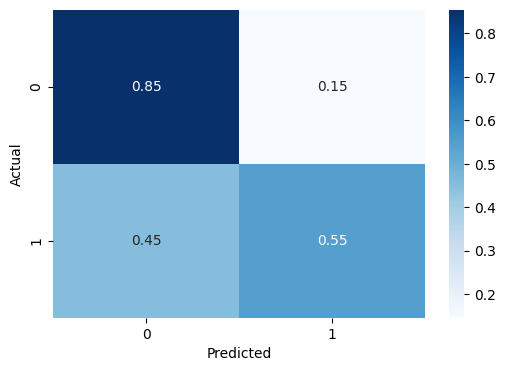

In [15]:
y_val_bagging_tune_pred = bagging_svm_tune.predict(X_val)
accuracy_tune = accuracy_score(y_val, y_val_bagging_tune_pred)

print(f'Accuracy: {accuracy_tune:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_tune_pred))
bagging_tune_confmat = confusion_matrix(y_val, y_val_bagging_tune_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_tune_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **PCA**
Choose the number of components for which the cumulative explained variance exceeds a threshold of 0.95 (95%).

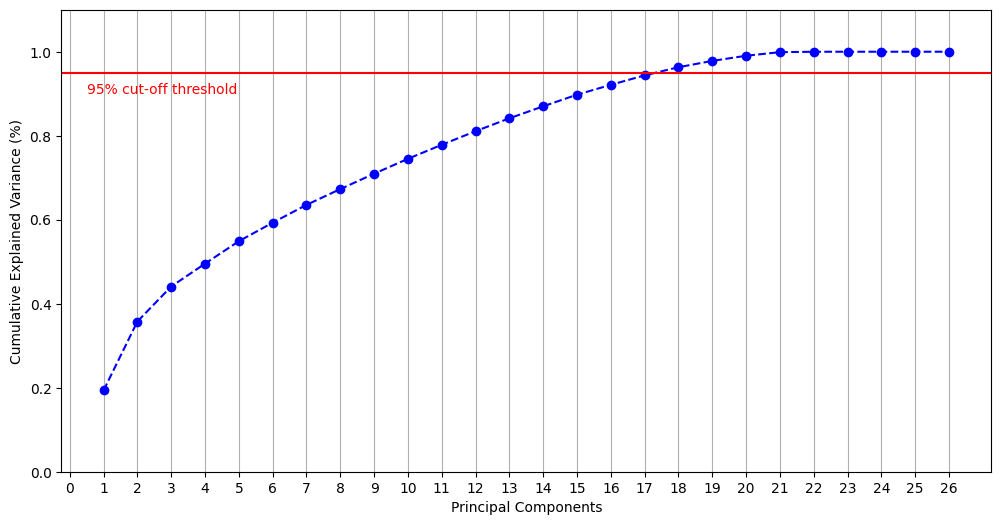

In [16]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 27, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Principal Components')
plt.xticks(np.arange(0, 27, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Explained Variance (%)')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red')

ax.grid(axis='x')
plt.show()

In [17]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

### **Bagging SVM with PCA**

In [19]:
bagging_svm_pca = BaggingClassifier(estimator=svm_classifier, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm_pca.fit(X_train_pca, y_train.values.ravel())

print(f'Training time: {time.time()-t0:.2f} s')

Training time: 5.78 s


Accuracy: 0.7688
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.83       515
           1       0.56      0.69      0.62       190

    accuracy                           0.77       705
   macro avg       0.72      0.75      0.73       705
weighted avg       0.79      0.77      0.78       705



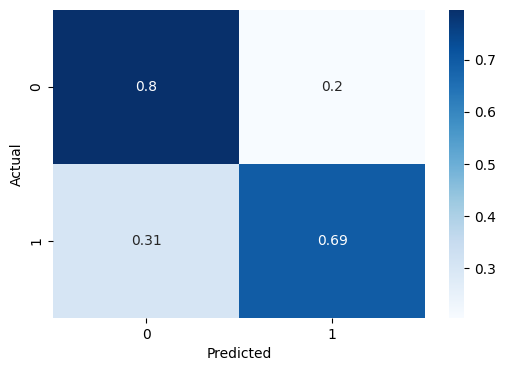

In [20]:
y_val_bagging_pca_pred = bagging_svm_pca.predict(X_val_pca)
accuracy_pca = accuracy_score(y_val, y_val_bagging_pca_pred)

print(f'Accuracy: {accuracy_pca:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_pca_pred))
bagging_pca_confmat = confusion_matrix(y_val, y_val_bagging_pca_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_pca_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### *Hyper-parameters Tuning SVM with PCA*

In [21]:
param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf','sigmoid']}
svm_pca_grid = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy', verbose=3)
svm_pca_grid.fit(X_train_pca,y_train.values.ravel())

# print best parameter after tuning 
print(svm_pca_grid.best_params_) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.740 total time=   2.1s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.3s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.2s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.2s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.500 total time=   2.2s
[CV 1/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.739 total time=   1.8s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   1.8s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   1.8s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   2.2s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.500 total time=   2.2s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.746 total time=   2.7s
[CV 2/5] END ....C=0.1, gamma=0.001, kerne

In [22]:
svm_pca_grid.best_estimator_

SVC(C=1, gamma=1, random_state=42)

In [23]:
svm_pca_grid.best_score_

0.8211544703838557

#### **Tuned Bagging SVM with PCA**

In [24]:
best_c = svm_pca_grid.best_params_.get('C')
best_gamma = svm_pca_grid.best_params_.get('gamma')

svm_pca_tune = SVC(gamma=best_gamma, C=best_c)

bagging_svm_pca_tune = BaggingClassifier(estimator=svm_pca_tune, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm_pca_tune.fit(X_train_pca, y_train.values.ravel())

print(f'Training time: {time.time()-t0:.2f} s')

Training time: 7.07 s


Accuracy: 0.7546
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       515
           1       0.54      0.55      0.55       190

    accuracy                           0.75       705
   macro avg       0.69      0.69      0.69       705
weighted avg       0.76      0.75      0.75       705



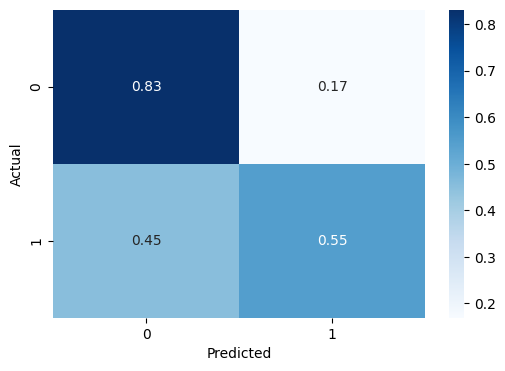

In [25]:
y_val_bagging_tune_pca_pred = bagging_svm_pca_tune.predict(X_val_pca)
accuracy_tune_pca = accuracy_score(y_val, y_val_bagging_tune_pca_pred)

print(f'Accuracy: {accuracy_tune_pca:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_tune_pca_pred))
bagging_tune_pca_confmat = confusion_matrix(y_val, y_val_bagging_tune_pca_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_tune_pca_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **Export Model**

In [26]:
import joblib

# Save model
joblib.dump(bagging_svm, './models/bagging_svm.sav')
joblib.dump(bagging_svm_tune, './models/bagging_svm_tune.sav')
joblib.dump(bagging_svm_pca, './models/bagging_svm_pca.sav')
joblib.dump(bagging_svm_pca_tune, './models/bagging_svm_pca_tune.sav')

['./models/bagging_svm_pca_tune.sav']